# Image Superresolution
## By: Mason Nolan

---

## Prerequisite Building Blocks

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def ResBlock(x, filters=64, kernel_size=(3, 3), scale=0.1): # The ResBlock: does not incorporate batch normalization, and includes a residual scaling layer.

    residual = x
    conv1 = layers.Conv2D(filters, kernel_size, padding='same')(x)
    relu1 = layers.ReLU()(conv1)
    conv2 = layers.Conv2D(filters, kernel_size, padding='same')(relu1)
    residual = conv2*scale # Residual scaling with a (default) factor of 0.1.

    out = layers.add([x, residual]) # Addition

    return out

The EDSR model can then be built from our blocks, where we begin and end with a convolution layer, before beginning PixelShuffle upsampling and one final convolution layer to output our superresolution image.

In [ ]:
def EDSR(scale_factor=2, num_residual_blocks=16, num_filters=64, image_size=(None, None, 3)):

    inputs = layers.Input(shape=image_size)

    x = layers.Conv2D(num_filters, (3, 3), padding='same')(inputs)
    for _ in range(num_residual_blocks): # All of our ResBlocks between two convolution layers
        x = ResBlock(x, filters=num_filters)
    x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)

    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale_factor))(x) # PixelShuffle upsampling

    outputs = layers.Conv2D(3, (3, 3), padding='same')(x)
    model = models.Model(inputs, outputs)
    return model

## Model

We now have the tools to build our model. We construct an initial model with 16 blocks and 64 filters, as to not become to cumbersome with number of parameters. We obtain a model with 1.2 million parameters (increasing to 32 ResBlocks increased the number of parameters to approximately 4.7 million, and number of filters to 256 drastically increase model complexity. 32 and 256 match the model in the paper, but I did not have the computational power or storage to run these parameters). Our model, to match the metrics and loss function established in the paper by Lim et al., we also establish SSIM and PSNR as metrics, and use L1 (MAE) as our lost functions instead of L2 (MSE)

In [ ]:
model1 = EDSR(scale_factor=2, num_residual_blocks=16, num_filters=64)

def ssim_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    max_val = tf.reduce_max(tf.abs(y_true))
    max_val = tf.maximum(max_val, 1.0)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=max_val))

def psnr_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    max_val = tf.reduce_max(tf.abs(y_true))
    max_val = tf.maximum(max_val, 1.0)
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=max_val))

model1.compile(optimizer='adam', loss='mae', metrics=[ssim_metric, psnr_metric]) # Note: we use the L1 loss function instead of the typical MSE/L2 loss, as the paper shows.

model1.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_659 (Conv2D)       │ (None, None, None, 64) │          1,792 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_660 (Conv2D)       │ (None, None, None, 64) │         36,928 │ conv2d_659[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_304 (ReLU)          │ (None, None, None, 64) │              0 │ conv2d_660[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_661 (Conv2D)       │ (None, None, None, 64) │         36,928 │ re_lu_304[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_304 (Multiply)   │ (None, None, None, 64) │              0 │ conv2d_661[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_304 (Add)             │ (None, None, None, 64) │              0 │ conv2d_659[0][0],      │
│                           │                        │                │ multiply_304[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_662 (Conv2D)       │ (None, None, None, 64) │         36,928 │ add_304[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_305 (ReLU)          │ (None, None, None, 64) │              0 │ conv2d_662[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_663 (Conv2D)       │ (None, None, None, 64) │         36,928 │ re_lu_305[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_305 (Multiply)   │ (None, None, None, 64) │              0 │ conv2d_663[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_305 (Add)             │ (None, None, None, 64) │              0 │ add_304[0][0],         │
│                           │                        │                │ multiply_305[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_664 (Conv2D)       │ (None, None, None, 64) │         36,928 │ add_305[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_306 (ReLU)          │ (None, None, None, 64) │              0 │ conv2d_664[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_665 (Conv2D)       │ (None, None, None, 64) │         36,928 │ re_lu_306[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_306 (Multiply)   │ (None, None, None, 64) │              0 │ conv2d_665[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_306 (Add)             │ (None, None, None, 64) │              0 │ add_305[0][0],         │
│                           │                        │                │ multiply_306[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_666 (Conv2D)  

 Total params: 1,220,851 (4.66 MB)

 Trainable params: 1,220,851 (4.66 MB)

 Non-trainable params: 0 (0.00 B)

## Training on the DIV2K Dataset

With our model built, lets import the DIV2K dataset. The dataset comes split already if the "as_supervised" parameter is set to True. We will also be defining a function to take a random chunk of the image to investigate and upsample. Upsampling the whole image is possible, but extremely storage intensive.

In [ ]:
dataset = tfds.load('div2k', as_supervised=True)
train_data = dataset['train']
test_data = dataset['validation']

def random_crop(image, label, patch_size=(32, 32)): # This function takes a patch of the images to use for super-resolution

    image_shape = tf.shape(image)
    label_shape = tf.shape(label)

    image_height, image_width = image_shape[0], image_shape[1]
    label_height, label_width = label_shape[0], label_shape[1]

    max_x = image_width - patch_size[1]
    max_y = image_height - patch_size[0]

    x = tf.random.uniform([], minval=0, maxval=max_x, dtype=tf.int32)
    y = tf.random.uniform([], minval=0, maxval=max_y, dtype=tf.int32)

    lr_patch = image[y:y+patch_size[0], x:x+patch_size[1]]
    hr_patch = label[2*y:2*y+2*patch_size[0], 2*x:2*x+2*patch_size[1]]

    return lr_patch, hr_patch

In [ ]:
train_data1 = train_data.map(lambda image, label: random_crop(image, label))
test_data1 = test_data.map(lambda image, label: random_crop(image, label))

Now, we create our batches of our data (with batch size = 16). We also "prefetch" our data, meaning while a batch is being used for training in our model, the images in the other batches are being loaded. This speeds up training time in our model and is just a convenience.

In [ ]:
train_data_batch = train_data1.batch(16).prefetch(tf.data.experimental.AUTOTUNE)
test_data_batch = test_data1.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

We are now ready to train our model.

In [ ]:
model1.fit(train_data_batch, validation_data=test_data_batch, epochs=16)

Epoch 1/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - loss: 36.1673 - psnr_metric: 17.6513 - ssim_metric: 0.3747 - val_loss: 8.8526 - val_psnr_metric: 26.6042 - val_ssim_metric: 0.7567
Epoch 2/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - loss: 8.4880 - psnr_metric: 27.5442 - ssim_metric: 0.7812 - val_loss: 8.8883 - val_psnr_metric: 27.7586 - val_ssim_metric: 0.8362
Epoch 3/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - loss: 7.6985 - psnr_metric: 29.1091 - ssim_metric: 0.8400 - val_loss: 7.6554 - val_psnr_metric: 29.2121 - val_ssim_metric: 0.8483
Epoch 4/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - loss: 7.5098 - psnr_metric: 29.3759 - ssim_metric: 0.8298 - val_loss: 6.7868 - val_psnr_metric: 30.1617 - val_ssim_metric: 0.8309
Epoch 5/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - loss: 6.6032 - psnr_metric: 30.5097 - ssim_metric: 0.8425 - val_loss: 5.4729 - val_psnr_metric: 31.2485 - val_ssim_metric: 0.8786
Epoch 6/16
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - loss: 5.4791 - psnr

## Final Results and Preview

Our final PSNR achieved was 34.41, and our final SSIM achieved was 0.9099. In comparison, the final model constructed in our reference paper achieved a PSNR of 35.03 and an SSIM of 0.9695.

We came close to matching the PSNR of the featured model, but we were fairly distant from achieving the SSIM that the featured model presented. These metrics may be improved by fine tuning, and adjustments to the architechture. The model presented also tuned the optimizer and included adjustments to the learning rate after so many minibatch updates.

Of its own accomplishment, lets view a demonstration of our model performing an upscaling on a chunk of a test image. On the left, we have the low-resolution chunk. In the middle, we have the full-resolution image, and on the right we have our model's prediction of the full-resolution image based on the low-resolution image. Reminder that we used an upscale factor of 2 during this notebook (we can use other factors in our model, but we would need to modify our random chunk function for other values).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


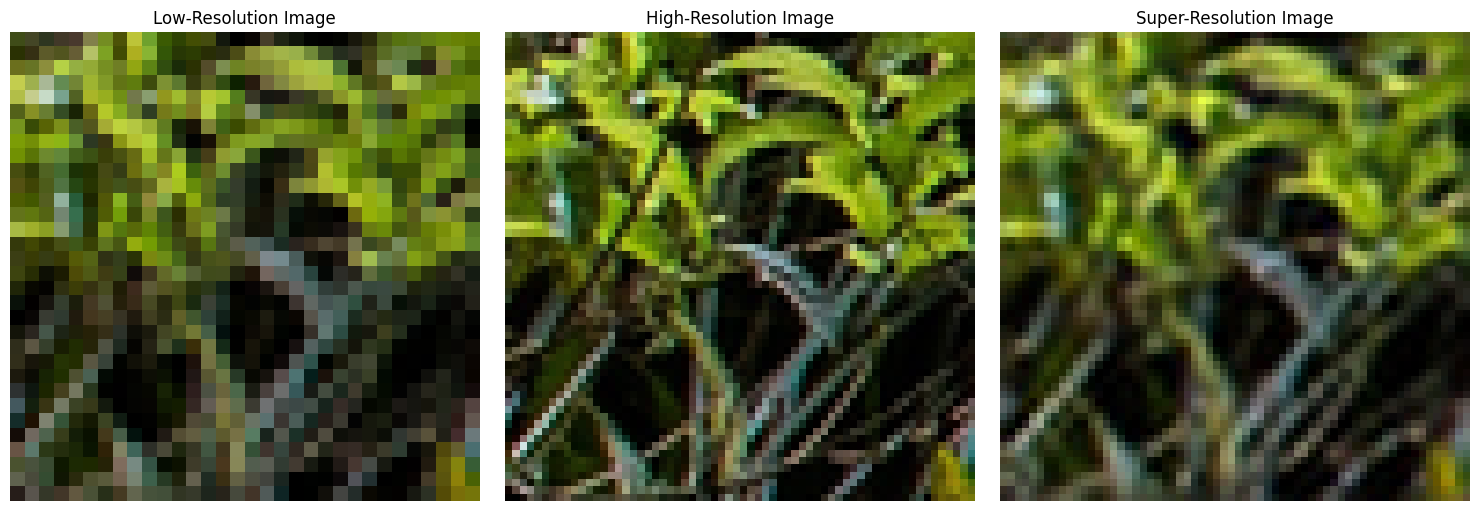

In [ ]:
iterator = iter(test_data_batch)
low_res_image, high_res_image = next(iterator)

low_res_image = low_res_image[0].numpy()
high_res_image = high_res_image[0].numpy()
super_res_image = model1.predict(np.expand_dims(low_res_image, axis=0))[0]
super_res_image = np.clip(super_res_image, 0, 255).astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(low_res_image)
axs[0].set_title('Low-Resolution Image')
axs[0].axis('off')
axs[1].imshow(high_res_image)
axs[1].set_title('High-Resolution Image')
axs[1].axis('off')
axs[2].imshow(super_res_image)
axs[2].set_title('Super-Resolution Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()